In [15]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 100

# font check
from matplotlib import font_manager as fm
for font in fm.fontManager.ttflist:
    if 'Pretendard' in font.name:
        print(font.name, font.fname)

# fe = fm.FontEntry(
#     fname=r'C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard.ttf', # ttf 파일이 저장되어 있는 경로
#     name='Pretendard')                       
# fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'Pretendard'})

plt.rcParams['font.family'] = 'Pretendard'

Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-SemiBold.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Bold.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Regular.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Black.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Medium.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-ExtraLight.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Light.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-ExtraBold.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Thin.ttf


In [ ]:
# 상장폐지 및 특수사례 제거
open_path = './_SNP_dataset/market_by_exchange'
save_path = './_SNP_dataset/market_by_exchange_FullPricingDate'
os.makedirs(save_path, exist_ok=True)  # Create the save directory if it doesn't exist
exchange = pd.read_csv('./_SNP_dataset/market_by_exchange/_exchangeSymbol.csv')

for i in exchange['exchange']:  # Replace 'column_name' with the actual column name
    file_path = f'{open_path}/{i}.parquet'
    if os.path.exists(file_path):  # Check if the file exists
        df = pd.read_parquet(file_path, engine='fastparquet')
        count = df.groupby('tickerSymbol').count()
        threshold = count['companyId'].describe()['75%'] # 특수사례 기준점
        count = count[count['companyId'] >= threshold]
        df = df[df['tickerSymbol'].isin(count.index)]
        df.to_parquet(f'{save_path}/{i}_FullPricingDate.parquet')
    else:
        print(f"File not found: {file_path}")

In [2]:
path = f'./_SNP_dataset\market_by_exchange_FullPricingDate'
df = pd.read_parquet(f'{path}/market_FullPricingDate.parquet', engine='fastparquet')

In [10]:
df['pricingDate'].unique()

<DatetimeArray>
['2023-10-10 00:00:00', '2023-10-09 00:00:00', '2023-10-06 00:00:00',
 '2023-10-05 00:00:00', '2023-10-04 00:00:00', '2023-10-03 00:00:00',
 '2023-10-02 00:00:00', '2023-09-28 00:00:00', '2023-09-27 00:00:00',
 '2023-09-26 00:00:00',
 ...
 '2017-03-18 00:00:00', '2018-06-09 00:00:00', '2018-12-22 00:00:00',
 '2018-03-31 00:00:00', '2017-09-30 00:00:00', '2017-06-03 00:00:00',
 '2021-08-28 00:00:00', '2017-08-19 00:00:00', '2017-05-13 00:00:00',
 '2017-02-18 00:00:00']
Length: 2158, dtype: datetime64[ns]

In [ ]:
path = f'./_SNP_dataset\market_by_exchange_FullPricingDate'
df = pd.read_parquet(f'{path}/market_FullPricingDate.parquet', engine='fastparquet')
temp = df.groupby('exchangeSymbol')['pricingDate'].unique()
# Assuming 'exchange_data' is your DataFrame with the series of dates
exchange_data = pd.DataFrame(temp)  # Replace with your actual DataFrame
exchange_data = exchange_data.reset_index()

# Initialize an empty DataFrame for the final output
all_exchanges_df = pd.DataFrame()

for index, row in exchange_data.iterrows():
    # Extract exchange symbol and pricing dates
    exchange_symbol = row['exchangeSymbol']
    pricing_dates = row['pricingDate']

    # Create a temporary DataFrame for this exchange
    temp_df = pd.DataFrame({
        'exchangeSymbol': exchange_symbol,
        'pricingDate': pricing_dates
    })

    # Concatenate with the main DataFrame
    all_exchanges_df = pd.concat([all_exchanges_df, temp_df], ignore_index=True)

exchange_data = all_exchanges_df
exchange_data['pricingDate'] = pd.to_datetime(exchange_data['pricingDate'])
date_counts = exchange_data.groupby('exchangeSymbol')['pricingDate'].count().reset_index().sort_values(by='pricingDate', ascending=False)

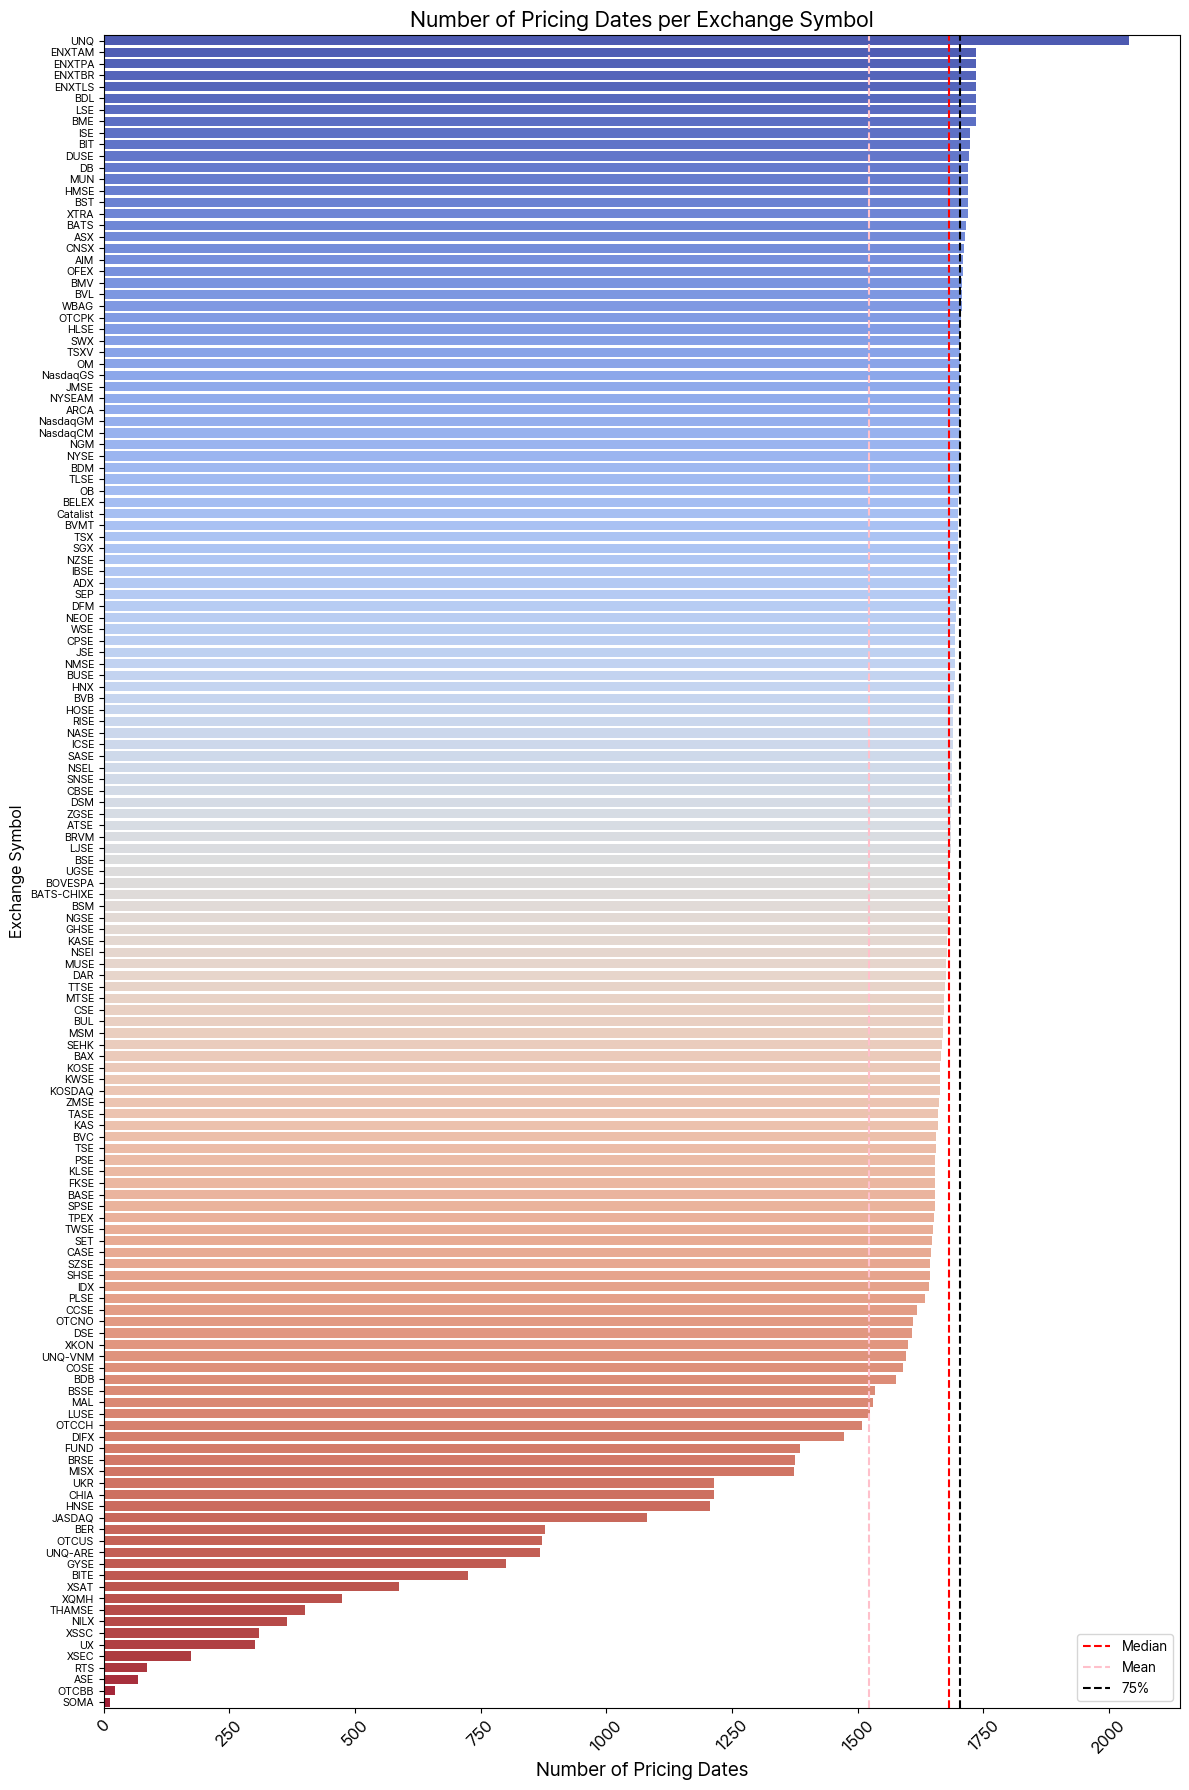

In [13]:
plt.figure(figsize=(12, 18))  # Increased width
barplot = sns.barplot(data=date_counts, y='exchangeSymbol', x='pricingDate', palette="coolwarm", hue='exchangeSymbol')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=8)
plt.axvline(x=date_counts['pricingDate'].median(), color='red', linestyle='--', label='Median')
plt.axvline(x=date_counts['pricingDate'].mean(), color='pink', linestyle='--', label='Mean')
plt.axvline(x=date_counts['pricingDate'].quantile(0.75), color='black', linestyle='--', label='75%')
plt.xlabel('Number of Pricing Dates', fontsize=14)
plt.ylabel('Exchange Symbol', fontsize=12)
plt.title('Number of Pricing Dates per Exchange Symbol', fontsize=16)
plt.legend()
plt.tight_layout()

## ISO 기준으로 필터링

In [ ]:
# 데이터 로드
path = f'./_SNP_dataset/market_by_exchange_FullPricingDate'
df = pd.read_parquet(f'{path}/market_FullPricingDate.parquet', engine='fastparquet')
df['pricingDate'] = pd.to_datetime(df['pricingDate'])
most_common_iso = df.groupby('exchangeSymbol')['ISOCode'].agg(lambda x: x.mode()[0]).reset_index(name='ISOCode')

# ISO 코드를 기준으로 필터링
filtered_df = pd.merge(df, most_common_iso, on=['exchangeSymbol', 'ISOCode'])
filtered_df.to_parquet(f'{path}/market_FullPricingDate_FilteredByISO.parquet')

# 특정 거래일자 기준 거래소 시가총액 계산

In [1]:
import pandas as pd

# exchangerate.parquet load
path = f'./_SNP_dataset'
exchangerate = pd.read_parquet(f'{path}/exchangerate.parquet', engine='fastparquet')

# 데이터 로드
path = f'./_SNP_dataset/market_by_exchange_FullPricingDate'
df = pd.read_parquet(f'{path}/market_FullPricingDate_FilteredByISO.parquet', engine='fastparquet')

In [12]:
df['pricingDate'] = pd.to_datetime(df['pricingDate'])
most_common_dates = df.groupby('exchangeSymbol')['pricingDate'].agg(lambda x: x.mode()[0]).reset_index(name='pricingDate')

# 원본 데이터와 병합하여 해당 거래일만 필터링
filtered_df = pd.merge(df, most_common_dates, on=['exchangeSymbol', 'pricingDate'])

# 각 거래소별 시가총액 합계 계산
exchange_market_caps = filtered_df.groupby('exchangeSymbol')['marketCap'].sum().reset_index()

# ISO 코드 결합
exchange_market_caps = pd.merge(exchange_market_caps, df[['exchangeSymbol', 'ISOCode']].drop_duplicates(), on='exchangeSymbol')

# 환율 정보 결합
exchangerate = exchangerate[exchangerate['priceDate'] == '2021-03-20']
combined_df = pd.merge(exchange_market_caps, exchangerate, on='ISOCode', how='inner')

# 시가총액을 환율로 나누어 USD 기준으로 변환
combined_df['marketCapUSD'] = combined_df['marketCap'] / combined_df['priceClose']
combined_df.sort_values(by='marketCapUSD', ascending=False, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

In [25]:
# 심볼 상위 24개만 선택
top_24_symbols = combined_df['exchangeSymbol'].loc[:23].tolist()
top_24_symbols

['NYSE',
 'NasdaqGS',
 'TSE',
 'NSEI',
 'SEHK',
 'ARCA',
 'LSE',
 'SHSE',
 'TSX',
 'ASX',
 'ENXTPA',
 'XTRA',
 'TWSE',
 'SWX',
 'BOVESPA',
 'SZSE',
 'OM',
 'BSE',
 'SASE',
 'NasdaqGM',
 'ENXTAM',
 'CPSE',
 'BME',
 'KOSE']

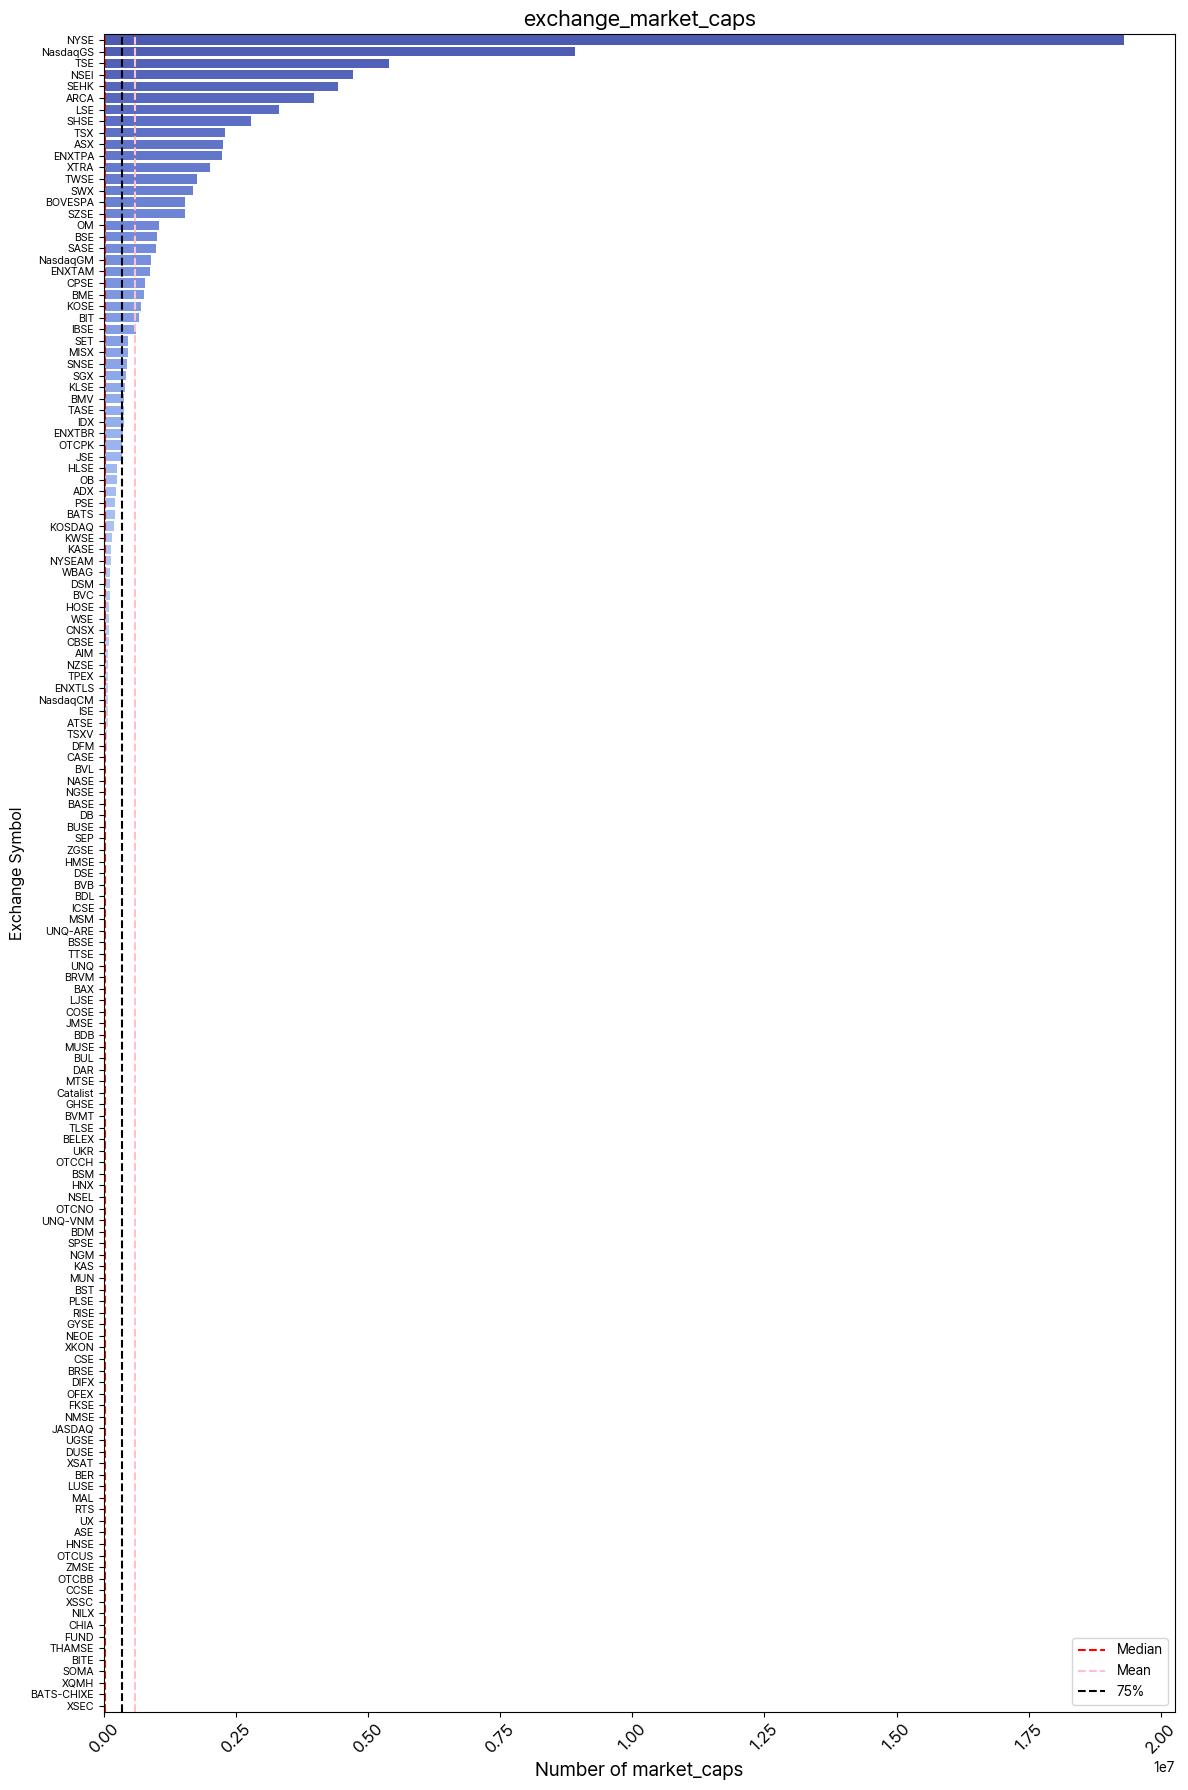

In [17]:
plt.figure(figsize=(12, 18))  # Increased width
barplot = sns.barplot(data=combined_df, y='exchangeSymbol', x='marketCapUSD', palette="coolwarm", hue='exchangeSymbol')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=8)
plt.axvline(x=combined_df['marketCapUSD'].median(), color='red', linestyle='--', label='Median')
plt.axvline(x=combined_df['marketCapUSD'].mean(), color='pink', linestyle='--', label='Mean')
plt.axvline(x=combined_df['marketCapUSD'].quantile(0.75), color='black', linestyle='--', label='75%')
plt.xlabel('Number of market_caps', fontsize=14)
plt.ylabel('Exchange Symbol', fontsize=12)
plt.title('exchange_market_caps', fontsize=16)
plt.legend()
plt.tight_layout()

In [27]:
# 상위 24개 거래소만 필터링해서 저장
top_24_df = df[df['exchangeSymbol'].isin(top_24_symbols)]
top_24_df.to_parquet(f'{path}/market_Top24_FullPricingDate.parquet')